In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
import warnings
import time
from tqdm import tqdm
import pylab
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Reviews.csv')

### EDA

In [3]:
df.shape

(568454, 10)

In [4]:
df.head(5)

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [5]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [6]:
df = df.drop_duplicates(subset=['Text', 'ProductId', 'UserId'], keep='first')
df.shape

(567145, 10)

We split our data to train, validation and test using a groupshuffle to keep the same products on the same set.

In [7]:
from sklearn.model_selection import GroupShuffleSplit
splitter_temp = GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 42)
split_temp = splitter_temp.split(df, groups=df['ProductId'])
train_inds, temp_inds = next(split_temp)

train = df.iloc[train_inds]
temp = df.iloc[temp_inds]

In [8]:
splitter_val = GroupShuffleSplit(test_size=.50, n_splits=1, random_state = 42)
split_val = splitter_val.split(temp, groups=temp['ProductId'])
val_inds, test_inds = next(split_val)

val = temp.iloc[val_inds]
test = temp.iloc[test_inds]

In [9]:
train.shape,val.shape,test.shape

((333029, 10), (115658, 10), (118458, 10))

### Lime Analysis

In [10]:
# Split train and test sets
X_train_lime = train[:50000].drop(columns = 'Score')
y_train_lime = train[:50000].Score

X_test_lime = test[:50000].drop(columns = 'Score')
y_test_lime = test[:50000].Score

In [11]:
from sklearn.linear_model import LogisticRegression

# Choose a model (e.g., Linear Regression)
model = LogisticRegression()

In [12]:
# Initialize the TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
vectorizer = TfidfVectorizer(min_df = 10,
                              max_features = 100000,
                              analyzer = "word",
                              ngram_range = (1, 2), # (2, 2) for just biograms
                              stop_words = 'english',
                              lowercase = True)

# Initialize a Logistic Regression model
model_lime = LogisticRegression(C = 0.5, solver = "sag")

# Create a pipeline object that combines the vectorization and logistic regression model steps
c = make_pipeline(vectorizer, model_lime)

In [13]:
!pip install lime

In [14]:
# Import LimeTextExplainer
from lime.lime_text import LimeTextExplainer

###### Split reviews into negative and positive

In [15]:
# Define a function to map the scores to the new labeling scheme
def map_labels(score):
    if score in [1, 2, 3]:
        return 0 # negative
    elif score in [4, 5]:
        return 1 # positive

y_train_mapped = y_train_lime.apply(map_labels)
y_test_mapped = y_test_lime.apply(map_labels)

In [16]:
display("Proportion of values in target:")
display(y_train_mapped.value_counts(normalize=True, dropna=False))
print()

'Proportion of values in target:'

1    0.77298
0    0.22702
Name: Score, dtype: float64

In [17]:
# Fit the pipeline to the training data. This process includes transforming the raw text data into TF-IDF
c.fit(X_train_lime['Text'], y_train_mapped)
y_pred_lime = c.predict(X_test_lime['Text'])

In [18]:
# Create classification report
class_report = classification_report(y_test_mapped, y_pred_lime, target_names=['negative', 'positive'])

print(f"Classification Report:\n{class_report}\n")

Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.50      0.63     11119
    positive       0.87      0.98      0.92     38881

    accuracy                           0.87     50000
   macro avg       0.86      0.74      0.77     50000
weighted avg       0.87      0.87      0.86     50000




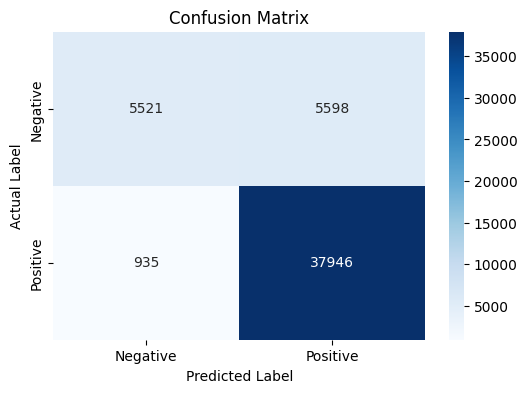

In [19]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_mapped, y_pred_lime)

# Visualize the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

##### Feature importance

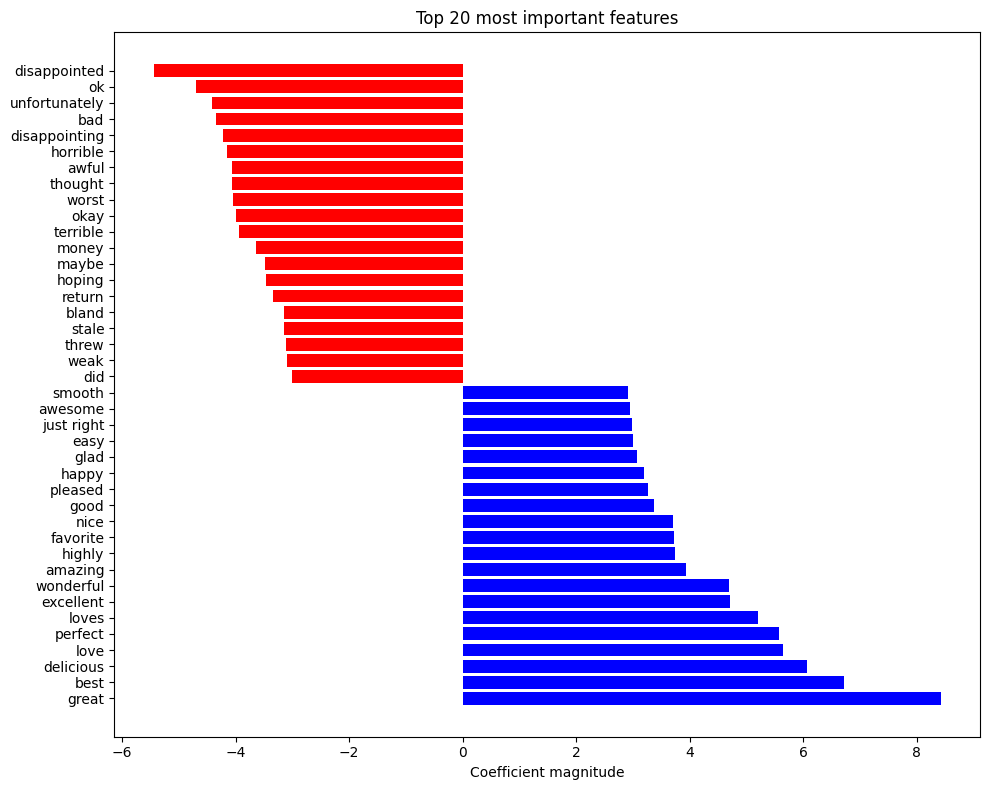

In [20]:
# Get the feature names from the vectorizer
feature_names = np.array(vectorizer.get_feature_names_out())

# Get the coefficients from the logistic regression model
coefs = model_lime.coef_[0]

# Sort the coefficients and corresponding feature names
sorted_indices = np.argsort(coefs)
sorted_coefs = coefs[sorted_indices]
sorted_features = feature_names[sorted_indices]

# Visualize the most important features
top_n = 20  # Number of features to visualize
plt.figure(figsize=(10, 8))

# Select the top n important features for positive and negative classes
top_positive_coefficients = sorted_coefs[-top_n:]
top_positive_features = sorted_features[-top_n:]
top_negative_coefficients = sorted_coefs[:top_n]
top_negative_features = sorted_features[:top_n]

# Combine for plotting
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
top_features = np.hstack([top_negative_features, top_positive_features])

# Assign colors based on the coefficient values
colors = ['red' if c < 0 else 'blue' for c in top_coefficients]

# Plot horizontal bar graph
plt.barh(np.arange(2 * top_n), top_coefficients, color=colors)
plt.yticks(np.arange(2 * top_n), top_features)
plt.gca().invert_yaxis()  # To display the highest value at the top
plt.xlabel('Coefficient magnitude')
plt.title('Top 20 most important features')
plt.tight_layout()
plt.show()

The model picks up relevent features for both negative and positive reviews.

**Top Negative**
- dissapointed
- ok & okay (from neutral?)
- unfortanately

**Top Positive**
- great
- best
- delicious

##### True Positive

In [21]:
# Initialize the LIME explainer for text data, specifying the class names for clearer explanations.
class_names = ['negative','positive']
explainer = LimeTextExplainer(class_names=class_names)

In [22]:
# Define actual and predicted
actual = np.array(y_test_mapped)
predicted = np.array(y_pred_lime)

# Find indices of true_positive and true negative
true_positives_indices = np.where((actual == 1) & (predicted == 1))[0]
true_negatives_indices = np.where((actual == 0) & (predicted == 0))[0]

# Analyze a true positive case with LIME
if true_positives_indices.size > 0:
    tp_index = true_positives_indices[0]  # Taking the first false positive instance
    tp_instance = X_test_lime.iloc[tp_index]['Text']
    tp_exp = explainer.explain_instance(tp_instance, c.predict_proba, num_features=10)
    tp_exp.show_in_notebook()

##### True Negative

In [23]:
# Analyze a true negative case with LIME
if true_negatives_indices.size > 0:
    tn_index = true_negatives_indices[0]  # Taking the first false negative instance
    tn_instance = X_test_lime.iloc[tn_index]['Text']
    tn_exp = explainer.explain_instance(tn_instance, c.predict_proba, num_features=10)
    tn_exp.show_in_notebook()

##### False Positive

In [24]:
# Find indices of false positives and false negatives
false_positives_indices = np.where((actual == 0) & (predicted == 1))[0]
false_negatives_indices = np.where((actual == 1) & (predicted == 0))[0]

# Analyze a false positive case with LIME
if false_positives_indices.size > 0:
    fp_index = false_positives_indices[0]  # Taking the first false positive instance
    fp_instance = X_test_lime.iloc[fp_index]['Text']
    fp_exp = explainer.explain_instance(fp_instance, c.predict_proba, num_features=10)
    fp_exp.show_in_notebook()

##### False Negative

In [25]:
# Analyze a false negative case with LIME
if false_negatives_indices.size > 0:
    fn_index = false_negatives_indices[0]  # Taking the first false negative instance
    fn_instance = X_test_lime.iloc[fn_index]['Text']
    fn_exp = explainer.explain_instance(fn_instance, c.predict_proba, num_features=10)
    fn_exp.show_in_notebook()

Insights:
- Feature importances not necessarily reflecting in lime
- Over-importance on food descriptioins
- "maybe" and "interested" being used for negative

## Text Clustering

##### *Train-Test Split*

In [26]:
num_samples = 50000

# Split train and test sets
X_train = train[:num_samples].drop(columns = 'Score')
y_train = train[:num_samples].Score

X_test = test[:num_samples].drop(columns = 'Score')
y_test = test[:num_samples].Score

In [27]:
import gensim.downloader as api
model = api.load('glove-wiki-gigaword-200')

In [28]:
# split reviews into words
corpus = " ".join(X_train['Text'])
words = corpus.split()

### *preprocessing*

In [29]:
# find words in reviews but not in dataset
found_words = []
missing_words = []

for word in words:
    if word in model.key_to_index:
      found_words.append(word)
    else:
      missing_words.append(word)

print(f"Number of words found in the model: {len(found_words)}")
print(f"Words not found in the model: {len(missing_words)}")

Number of words found in the model: 2975794
Words not found in the model: 1029234


##### *Filter by Frequency*

In [30]:
from collections import Counter

# Count the frequency of each word
word_counts = Counter(found_words)
total_words = sum(word_counts.values())

# Set a frequency thresholds
min_percentage = 0.0000001
max_percentage = 0.70

# Filter words by percentage range
filtered_words = [word for word in found_words if min_percentage <= (word_counts[word] / total_words) <= max_percentage]

# Update found_words
found_words = set(filtered_words)
print("Number of words:", len(found_words))


Number of words: 24716


##### *Remove Stop Words*

In [31]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Filter out stop words from found_words
found_words = [word for word in found_words if word not in stop_words]
print("Number of words:", len(found_words))

Number of words: 24578


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### *Part-of-Speech (POS) Tagging*

In [32]:
part_of_speech = 'JJ' # adjectives

import nltk
nltk.download('averaged_perceptron_tagger')

# Filter words by part of speech, keeping only nouns, for example
found_words = [word for word, pos in nltk.pos_tag(found_words) if pos.startswith(part_of_speech)]
print("Number of words:", len(found_words))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Number of words: 5883


In [33]:
# use only shared words
X = model[found_words]

print("Dimensions of the matrix X:", X.shape)

Dimensions of the matrix X: (5883, 200)


In [34]:
# n_clusters=10

# kmeans = KMeans(n_clusters=n_clusters, random_state=1)
# kmeans.fit(X)
# labels = kmeans.labels_

# # Create a dictionary to hold words for each cluster
# clusters = {}

# # Loop through labels and words together
# for word, label in zip(found_words, labels):
#     # Append the word to the corresponding cluster's list
#     clusters.setdefault(label, []).append(word)

# # Print the first few words from each cluster
# for cluster_id in sorted(clusters.keys()):
#     words = clusters[cluster_id]
#     print(f"Words in cluster {cluster_id}:", clusters[:10])

Time taken for 4 clusters: 0.6510021686553955 seconds


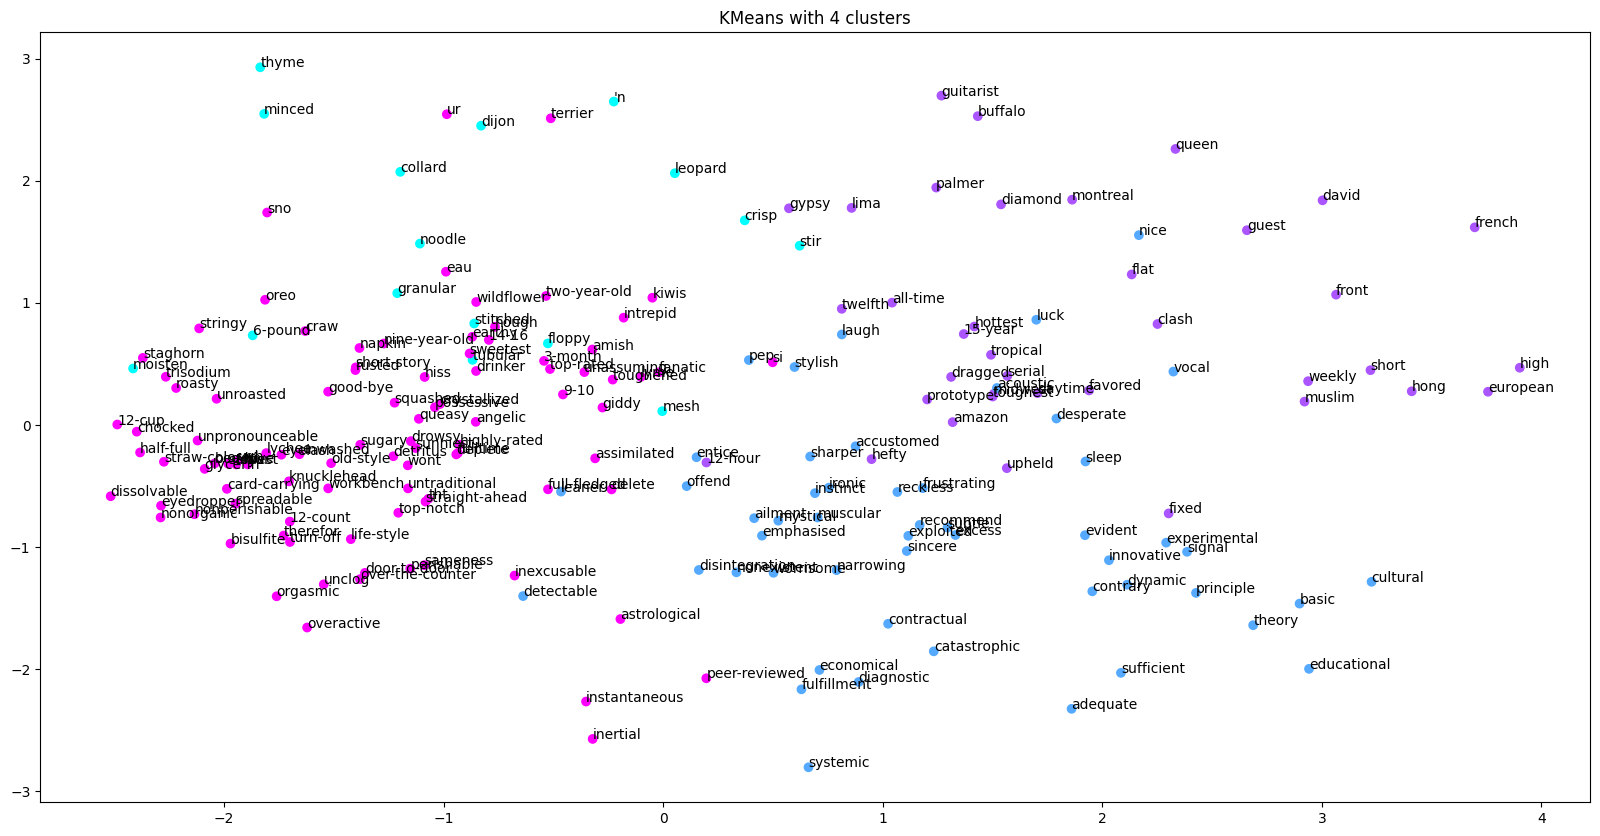

In [35]:
found_words_200 = found_words[:200]
X_reduced = model[found_words_200]

n_clusters= 4

start_time = time.time()  # Start timing

kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X_reduced)
labels = kmeans.labels_

# Run PCA on the word vectors
pca = PCA(n_components=2)
Y = pca.fit_transform(X_reduced)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.scatter(Y[:, 0], Y[:, 1], c=labels, cmap=pylab.cm.cool)

for i, word in enumerate(found_words_200):
    ax.annotate(word, xy=(Y[i, 0], Y[i, 1]))

plt.title(f'KMeans with {n_clusters} clusters')

end_time = time.time()  # End timing
print(f"Time taken for {n_clusters} clusters: {end_time - start_time} seconds")

plt.show()  # To display the plot for each cluster number

TODO:
- NLP 3
- "Verb + ADJ" by each classifcation
- Supervised Model

# Ordered Phrasing: Verb + Adjective

TODO:
- break out sentecnes by phrases (Spacy models to break down sentences into phrases)
- Do sentiment analysis on each phrase, how do we identify sentiment of adjectives
- Add subject to these tuples below (we want product as subject, maybe nouns)
- Add word before verb ("not")
- Find reviews: "The food does not taste great", "It tastes great, but smells bad"
- Important to split into phrases
- Step1: Split - Adjective in noun phrase, must inlcude "not" for sentiment analysis
- Step2: Sentiment Anaysis - positive or negative?
- Step3: Subject - what is positive? The pickles, flavor, cheeseberger,...

1. Add adverbs
2. Create displacy.render plots

In [36]:
y_train_df = pd.DataFrame(y_train)
full_train = pd.concat([X_train, y_train_df], axis=1)

train_negative = full_train[full_train['Score'].isin([1, 2])]
train_neutral = full_train[full_train['Score'] == 3]
train_positive = full_train[full_train['Score'].isin([4, 5])]

corpus_negative = train_negative['Text'].tolist()
corpus_neutral = train_neutral['Text'].tolist()
corpus_positive = train_positive['Text'].tolist()

In [37]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [38]:
# Verb + Adjective
def find_top_verb_adj_pairs_top100(corpus, top_n=100):
    pairs = []
    for doc in nlp.pipe(corpus, disable=["ner"]):  # Disable named entity recognition for efficiency
        for token in doc:
            if token.pos_ == "VERB":
                next_token = token.nbor(1) if token.i + 1 < len(doc) else None
                if next_token and next_token.pos_ == "ADJ":
                    pairs.append((token.lemma_, next_token.lemma_))

    # Count the frequency of each pair and return the top_n most common pairs
    pair_counts = Counter(pairs)
    return pair_counts.most_common(top_n)

In [39]:
# Word + Verb + Adjective
def find_top_word_verb_adj_pairs_top100(corpus, top_n=100):
    pairs = []
    for doc in nlp.pipe(corpus, disable=["ner"]):  # Disable named entity recognition for efficiency
        for token in doc:
            if token.pos_ == "VERB":
                prev_token = token.nbor(-1) if token.i - 1 >= 0 else None
                next_token = token.nbor(1) if token.i + 1 < len(doc) else None
                if prev_token and next_token and next_token.pos_ == "ADJ":
                    pairs.append((prev_token.lemma_, token.lemma_, next_token.lemma_))

    # Count the frequency of each pair and return the top_n most common pairs
    pair_counts = Counter(pairs)
    return pair_counts.most_common(top_n)

In [40]:
# Subject + Word + Verb + Adjective
def find_top_subj_preverb_verb_adj_pairs(corpus, top_n=100):
    pairs = []
    for doc in nlp.pipe(corpus, disable=["ner"]):  # We might need the parser for accurate subject detection
        for token in doc:
            if token.pos_ == "VERB":
                subject = None
                pre_verb = None
                adjective = None

                # Look for the subject connected to the verb
                for child in token.children:
                    if child.dep_ in ["nsubj", "nsubjpass"]:  # nsubjpass is for passive voice
                        subject = child.lemma_

                # Get the word before the verb, if it exists
                if token.i > 0:
                    pre_verb = doc[token.i - 1].lemma_

                # Look for the adjective connected to the verb or its children
                if token.i + 1 < len(doc) and token.nbor(1).pos_ == "ADJ":
                    adjective = token.nbor(1).lemma_
                else:
                    for child in token.children:
                        if child.pos_ == "ADJ":
                            adjective = child.lemma_
                            break

                if subject and pre_verb and adjective:
                    pairs.append((subject, pre_verb, token.lemma_, adjective))

    # Count the frequency of each tuple and return the top_n most common
    pair_counts = Counter(pairs)
    return pair_counts.most_common(top_n)

In [41]:
# Subject + Verb + Adjective + Adverb
def find_top_subj_verb_adj_adv_pairs(corpus, top_n=100):
    pairs = []
    for doc in nlp.pipe(corpus, disable=["ner"]):  # Parser is needed for accurate dependency detection
        for token in doc:
            if token.pos_ == "VERB":
                subject = None
                adjective = None
                adverb = None

                # Look for the subject connected to the verb
                for child in token.children:
                    if child.dep_ in ["nsubj", "nsubjpass"]:  # nsubjpass is for passive voice
                        subject = child.lemma_

                # Look for the adjective and adverb connected to the verb or its children
                for child in token.children:
                    if child.pos_ == "ADJ":
                        adjective = child.lemma_
                        # Search for an adverb modifying the adjective
                        for grandchild in child.children:
                            if grandchild.pos_ == "ADV":
                                adverb = grandchild.lemma_
                                break
                    elif child.pos_ == "ADV" and not adverb:  # Adverb modifying the verb
                        adverb = child.lemma_

                if subject and adjective and adverb:
                    pairs.append((subject, token.lemma_, adjective, adverb))

    # Count the frequency of each tuple and return the top_n most common
    pair_counts = Counter(pairs)
    return pair_counts.most_common(top_n)

TODO:
- Add word before verb (is there not), mabye add subject
- Sentiment analysis model (get score)
- Group by subject: share insight

#### *Verb + Adjective Phrasing*

##### *Negative Reviews*

In [42]:
# verb-adjective pairs in each corpus
verb_adj_pairs_negative = find_top_verb_adj_pairs_top100(corpus_negative)
verb_adj_pairs_negative # why is taste good appearing here? Drill down on scenarios

[(('taste', 'good'), 103),
 (('gluten', 'free'), 59),
 (('make', 'sure'), 58),
 (('have', 'more'), 51),
 (('have', 'high'), 47),
 (('taste', 'great'), 39),
 (('taste', 'awful'), 31),
 (('taste', 'horrible'), 31),
 (('taste', 'bad'), 30),
 (('try', 'many'), 27),
 (('get', 'sick'), 27),
 (('try', 'other'), 27),
 (('pay', 'more'), 25),
 (('have', 'little'), 25),
 (('add', 'more'), 24),
 (('have', 'good'), 23),
 (('taste', 'terrible'), 22),
 (('go', 'bad'), 20),
 (('have', 'well'), 20),
 (('be', 'well'), 19),
 (('have', 'several'), 19),
 (('have', 'great'), 19),
 (('have', 'many'), 18),
 (('buy', 'more'), 18),
 (('get', 'more'), 17),
 (('be', 'many'), 17),
 (('try', 'several'), 17),
 (('have', 'much'), 17),
 (('have', 'different'), 17),
 (('taste', 'stale'), 17),
 (('eat', 'more'), 17),
 (('get', 'well'), 16),
 (('smell', 'bad'), 16),
 (('taste', 'bitter'), 15),
 (('have', 'other'), 15),
 (('have', 'bad'), 15),
 (('get', 'enough'), 15),
 (('smell', 'good'), 15),
 (('expect', 'more'), 14),


In [43]:
# word-verb-adjective pairs in each corpus
word_verb_adj_pairs_negative = find_top_word_verb_adj_pairs_top100(corpus_negative)
word_verb_adj_pairs_negative

[(('I', 'have', 'high'), 31),
 (('not', 'taste', 'good'), 31),
 (('to', 'make', 'sure'), 27),
 (('there', 'be', 'well'), 19),
 (('have', 'try', 'many'), 19),
 (('there', 'be', 'many'), 17),
 (('not', 'have', 'much'), 16),
 (('it', 'taste', 'good'), 14),
 (('there', 'be', 'other'), 14),
 (('there', 'be', 'more'), 11),
 (('be', 'gluten', 'free'), 10),
 (('they', 'taste', 'good'), 10),
 (('I', 'expect', 'more'), 9),
 (('have', 'try', 'other'), 9),
 (('it', 'have', 'more'), 8),
 (('to', 'try', 'new'), 8),
 (('it', 'taste', 'bad'), 8),
 (('not', 'get', 'enough'), 8),
 (('it', 'taste', 'bitter'), 7),
 (('have', 'have', 'several'), 7),
 (('to', 'eat', 'healthy'), 7),
 (('there', 'be', 'little'), 7),
 (('have', 'have', 'other'), 7),
 (('it', 'taste', 'great'), 7),
 (('I', 'feel', 'bad'), 7),
 (('dog', 'get', 'sick'), 7),
 (('have', 'have', 'well'), 7),
 (('it', 'taste', 'awful'), 6),
 (('have', 'try', 'several'), 6),
 (('do', 'taste', 'good'), 6),
 (('I', 'try', 'several'), 6),
 (('not', 'tast

In [44]:
def find_sentences_with_pattern(corpus, target_tuple=('it', 'taste', 'good')):
    sentences_with_pattern = []
    for doc in nlp.pipe(corpus, disable=["ner"]):  # Disable named entity recognition for efficiency
        for token in doc:
            if token.pos_ == "VERB":
                prev_token = token.nbor(-1) if token.i - 1 >= 0 else None
                next_token = token.nbor(1) if token.i + 1 < len(doc) else None
                if prev_token and next_token and next_token.pos_ == "ADJ":
                    if (prev_token.lemma_, token.lemma_, next_token.lemma_) == target_tuple:
                        sentences_with_pattern.append(doc.text)
                        break  # Assuming you only need one instance of this pattern per sentence

    return sentences_with_pattern

In [45]:
# Drilling down on "it taste good"
find_sentences_with_pattern(corpus_negative)

['You have to put a lot of sugar in  this to make it taste good. The coffee just by itself kind if has a stinky smell like a poopy diaper or a pee pee poo poo puppy in a cup. Next time I am going for raspberry flavored coffee...cause the chocolate is like poop. YUCK.',
 "This is awful tasting and for the price with shipping turned out to be $10 a bottle. Bought for my son's birthday party and some of the boys were puking and gaging it was so bad. You are better off buying a bottle of Franks hot sauce and chugging it down...at least it tastes good. This was my BIGGEST rip-off buy EVER!!!",
 'On an empty stomach, in a controlled environment, with plenty of water, I felt no physical change to stress levels, at least not the way that you feel an immediate sense of relaxation from Xanax. Like homeopathic medicince (highly diluted), this product is bunk.<br /><br />But it tastes good, and maybe it could have a little placebo effect.',
 'I was born and raised in India and I cook a lot.  I had

In [46]:
# subject + word-verb-adjective pairs in each corpus
find_top_subj_preverb_verb_adj_pairs
find_top_subj_preverb_verb_adj_pairs(corpus_negative)

# filter redundant words

[(('I', 'I', 'have', 'high'), 31),
 (('it', 'it', 'taste', 'good'), 20),
 (('it', 'it', 'taste', 'bad'), 19),
 (('I', 'have', 'try', 'many'), 17),
 (('I', 'I', 'expect', 'more'), 14),
 (('they', 'they', 'taste', 'good'), 11),
 (('I', 'I', 'feel', 'bad'), 11),
 (('it', 'it', 'taste', 'bitter'), 10),
 (('it', 'not', 'taste', 'good'), 10),
 (('it', 'it', 'make', 'sick'), 10),
 (('it', 'it', 'smell', 'bad'), 9),
 (('it', 'it', 'taste', 'awful'), 8),
 (('they', 'not', 'taste', 'good'), 8),
 (('it', 'it', 'have', 'more'), 8),
 (('I', 'I', 'like', 'strong'), 8),
 (('I', 'be', 'expect', 'more'), 8),
 (('it', 'it', 'sound', 'good'), 8),
 (('it', 'it', 'taste', 'well'), 7),
 (('it', 'it', 'taste', 'great'), 7),
 (('I', 'have', 'try', 'other'), 7),
 (('it', 'it', 'taste', 'horrible'), 7),
 (('I', 'I', 'get', 'excited'), 7),
 (('I', 'I', 'find', 'weak'), 6),
 (('I', 'have', 'have', 'several'), 6),
 (('I', 'I', 'm', 'sure'), 6),
 (('they', 'they', 'taste', 'bad'), 6),
 (('I', 'I', 'try', 'several')

In [47]:
find_top_subj_verb_adj_adv_pairs = find_top_subj_verb_adj_adv_pairs(corpus_negative)
find_top_subj_verb_adj_adv_pairs

[(('it', 'taste', 'good', 'very'), 6),
 (('Diamond', 'see', 'fit', 'apparently'), 4),
 (('they', 'make', 'hard', 'first'), 4),
 (('almond', 'taste', 'good', 'pretty'), 4),
 (('I', 'sound', 'stupid', 'really'), 3),
 (('which', 'make', 'attractive', 'more'), 3),
 (('she', 'become', 'hungry', 'more'), 3),
 (('/>I', 'feel', 'bad', 'so'), 3),
 (('I', 'try', 'hard', 'really'), 3),
 (('it', 'taste', 'bad', 'as'), 3),
 (('that', 'taste', 'good', 'actually'), 3),
 (('I', 'expect', 'more', 'much'), 3),
 (('I', 'try', 'bland', 'rather'), 3),
 (('one', 'cost', 'cheap', 'way'), 3),
 (('I', 'm', 'disappointed', 'really'), 3),
 (('I', 'feel', 'comfortable', 'just'), 3),
 (('it', 'smell', 'bad', 'really'), 3),
 (('it', 'taste', 'bad', 'so'), 3),
 (('I', 'pay', 'more', 'rather'), 3),
 (('I', 'find', 'disappointing', 'far'), 3),
 (('flavor', 'remind', 'much', 'so'), 3),
 (('I', 'steep', 'little', 'long'), 3),
 (('Honey', 'do', 'much', 'either'), 3),
 (('I', 'm', 'willing', 'so'), 3),
 (('that', 's', 'ba

##### *Positve Reviews*

In [48]:
# Find top 100 verb-adjective pairs in each corpus
verb_adj_pairs_positive = find_top_verb_adj_pairs_top100(corpus_positive)
verb_adj_pairs_positive

[(('taste', 'great'), 873),
 (('gluten', 'free'), 560),
 (('taste', 'good'), 523),
 (('make', 'sure'), 429),
 (('try', 'many'), 309),
 (('buy', 'more'), 298),
 (('work', 'great'), 272),
 (('have', 'more'), 250),
 (('order', 'more'), 238),
 (('try', 'other'), 204),
 (('go', 'wrong'), 195),
 (('try', 'several'), 174),
 (('get', 'more'), 171),
 (('feel', 'good'), 171),
 (('get', 'enough'), 152),
 (('have', 'great'), 149),
 (('make', 'great'), 125),
 (('go', 'crazy'), 124),
 (('have', 'good'), 112),
 (('have', 'enough'), 109),
 (('want', 'more'), 96),
 (('get', 'sick'), 95),
 (('have', 'less'), 94),
 (('smell', 'good'), 92),
 (('stay', 'fresh'), 87),
 (('add', 'more'), 86),
 (('have', 'many'), 85),
 (('look', 'great'), 85),
 (('eat', 'healthy'), 82),
 (('go', 'great'), 79),
 (('feel', 'guilty'), 79),
 (('get', 'tired'), 74),
 (('eat', 'more'), 72),
 (('taste', 'well'), 69),
 (('have', 'several'), 69),
 (('like', 'strong'), 66),
 (('feel', 'well'), 65),
 (('use', 'less'), 64),
 (('smell', '

In [49]:
# word-verb-adjective pairs in each corpus
word_verb_adj_pairs_positive = find_top_word_verb_adj_pairs_top100(corpus_positive)
word_verb_adj_pairs_positive

[(('have', 'try', 'many'), 238),
 (('it', 'taste', 'great'), 214),
 (('not', 'go', 'wrong'), 153),
 (('it', 'taste', 'good'), 126),
 (('have', 'try', 'several'), 122),
 (('to', 'make', 'sure'), 120),
 (('not', 'get', 'enough'), 120),
 (('and', 'taste', 'great'), 116),
 (('be', 'gluten', 'free'), 107),
 (('they', 'taste', 'great'), 105),
 (('have', 'try', 'other'), 103),
 (('I', 'feel', 'good'), 94),
 (('be', 'buy', 'more'), 81),
 (('be', 'order', 'more'), 74),
 (('it', 'work', 'great'), 69),
 (('to', 'buy', 'more'), 62),
 (('to', 'get', 'more'), 55),
 (('they', 'taste', 'good'), 53),
 (('there', 'be', 'more'), 52),
 (('there', 'be', 'many'), 50),
 (('to', 'order', 'more'), 50),
 (('not', 'say', 'enough'), 49),
 (('will', 'buy', 'more'), 45),
 (('just', 'make', 'sure'), 45),
 (('and', 'taste', 'good'), 45),
 (('not', 'have', 'much'), 43),
 (('to', 'eat', 'healthy'), 42),
 ((',', 'make', 'sure'), 36),
 (('not', 'feel', 'guilty'), 36),
 (('good', 'gluten', 'free'), 34),
 (('that', 'taste'

In [50]:
# subject + word-verb-adjective pairs in each corpus
find_top_subj_preverb_verb_adj_pairs
find_top_subj_preverb_verb_adj_pairs(corpus_positive)

[(('it', 'it', 'taste', 'good'), 255),
 (('it', 'it', 'taste', 'great'), 227),
 (('I', 'have', 'try', 'many'), 183),
 (('you', 'not', 'go', 'wrong'), 128),
 (('they', 'they', 'taste', 'good'), 109),
 (('they', 'they', 'taste', 'great'), 105),
 (('I', 'I', 'feel', 'good'), 102),
 (('I', 'have', 'try', 'several'), 99),
 (('I', 'have', 'try', 'other'), 83),
 (('it', 'it', 'work', 'great'), 79),
 (('I', 'be', 'order', 'more'), 55),
 (('that', 'that', 'taste', 'good'), 53),
 (('little', 'little', 'go', 'little'), 50),
 (('I', 'I', 'like', 'strong'), 50),
 (('I', 'be', 'buy', 'more'), 49),
 (('old', 'old', 'love', 'old'), 48),
 (('it', 'it', 'taste', 'well'), 41),
 (('I', 'I', 'feel', 'well'), 40),
 (('you', 'you', 'like', 'strong'), 38),
 (('it', 'it', 'have', 'more'), 38),
 (('I', 'not', 'get', 'enough'), 37),
 (('it', 'it', 'smell', 'good'), 36),
 (('I', 'not', 'say', 'enough'), 35),
 (('dog', 'dog', 'go', 'crazy'), 34),
 (('I', 'I', 'like', 'good'), 33),
 (('it', 'it', 'have', 'good'), 2

##### *Neutral Reviews*

In [51]:
# Find top 100 verb-adjective pairs in each corpus
verb_adj_pairs_neutral = find_top_verb_adj_pairs_top100(corpus_neutral)
verb_adj_pairs_neutral

[(('taste', 'good'), 79),
 (('gluten', 'free'), 43),
 (('make', 'sure'), 41),
 (('taste', 'great'), 35),
 (('have', 'more'), 34),
 (('add', 'more'), 30),
 (('have', 'enough'), 23),
 (('try', 'other'), 21),
 (('have', 'high'), 21),
 (('buy', 'more'), 17),
 (('like', 'strong'), 17),
 (('get', 'more'), 16),
 (('work', 'great'), 15),
 (('have', 'good'), 15),
 (('have', 'well'), 15),
 (('have', 'less'), 15),
 (('have', 'much'), 15),
 (('be', 'well'), 14),
 (('expect', 'more'), 13),
 (('smell', 'good'), 13),
 (('taste', 'fine'), 13),
 (('have', 'great'), 13),
 (('pay', 'more'), 12),
 (('use', 'more'), 12),
 (('be', 'other'), 12),
 (('taste', 'ok'), 12),
 (('want', 'more'), 11),
 (('have', 'many'), 10),
 (('eat', 'more'), 10),
 (('sound', 'good'), 10),
 (('have', 'little'), 10),
 (('look', 'good'), 10),
 (('order', 'more'), 9),
 (('try', 'several'), 9),
 (('taste', 'different'), 9),
 (('get', 'well'), 9),
 (('taste', 'bad'), 9),
 (('smell', 'great'), 9),
 (('have', 'other'), 8),
 (('add', 'ex

# Supervised Model

In [52]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

In [53]:
import re
from nltk.tokenize import word_tokenize
import nltk

# Download the 'punkt' tokenizer models
nltk.download('punkt')

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'\W', ' ', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words (ensure stopwords are downloaded first)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Return the cleaned text
    return ' '.join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [54]:
# Apply preprocessing to each text entry
preprocessed_text = [preprocess_text(text) for text in X_train['Text']]

In [55]:
# split reviews into words
corpus = " ".join(preprocessed_text)
words = corpus.split()
print("Number of Words:", len(words))

Number of Words: 2082283


In [56]:
x = preprocessed_text
token = Tokenizer() # puts ID to word
token.fit_on_texts(x)
seq = token.texts_to_sequences(x)

In [57]:
pad_seq = pad_sequences(seq,maxlen=300)

In [58]:
pad_seq

array([[   0,    0,    0, ..., 8033,    6,   31],
       [   0,    0,    0, ..., 6795,    6, 4675],
       [   0,    0,    0, ...,  437,    9, 2952],
       ...,
       [   0,    0,    0, ...,    8, 4540, 2524],
       [   0,    0,    0, ...,   17,  457,   58],
       [   0,    0,    0, ...,  179,   67,    6]], dtype=int32)

In [59]:
vocab_size = len(token.word_index)+1

In [60]:
# Download GloVe embeddings (this might take some time due to the large size of the file)
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

# Unzip the downloaded file
!unzip glove.840B.300d.zip

# Now you should have the 'glove.840B.300d.txt' file in the current directory

--2024-03-22 11:36:57--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2024-03-22 11:36:57--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2024-03-22 11:36:57--  https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/

In [61]:
embedding_vector = {}
with open('glove.840B.300d.txt', 'r', encoding='utf-8') as f:
    for line in tqdm(f):
        values = line.split(' ')
        word = values[0]
        coef = np.array(values[1:], dtype='float32')
        embedding_vector[word] = coef

2196017it [02:11, 16693.36it/s]


In [62]:
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 41155/41155 [00:00<00:00, 261009.95it/s]


In [63]:
# Assuming y_train is a list or a similar iterable with scores
# Map scores: 5 and 4 to 1 (positive), 1 and 2 to 0 (negative)
y_train_binary = [1 if score >= 4 else 0 for score in y_train]
y_train_binary = np.array(y_train_binary)

In [64]:
# # Try embedding before modeling: instead of pad_seq, give embedded vectors.
# model = Sequential()
# model.add(Embedding(vocab_size,300,weights = [embedding_matrix],input_length=300,trainable = False))
# model.add(Bidirectional(LSTM(75)))
# model.add(Dense(32,activation = 'relu'))
# model.add(Dense(1,activation = 'sigmoid'))
# model.compile(optimizer='adam',loss='binary_crossentropy',metrics = ['accuracy'])
# history = model.fit(pad_seq,y_train_binary,epochs = 5,batch_size=36,validation_split=0.2)

##### Extra

In [65]:
# # First step: KMeans fitting
# kmeans = KMeans(n_clusters=4, random_state=0)
# kmeans.fit(X)

# # Second step: PCA transformation
# pca = PCA(n_components=2)
# Y = pca.fit_transform(X)

# # Third step: Plotting
# fig = plt.figure(figsize=(20, 10))
# ax = fig.add_subplot(111)
# ax.scatter(Y[:, 0], Y[:, 1], c=kmeans.labels_, cmap=pylab.cm.cool)

# for i, word in enumerate(found_words):
#     ax.annotate(word, xy=(Y[i, 0], Y[i, 1]))

# plt.title(f'KMeans with 4 clusters')
# plt.show()  # To display the plot for each cluster number

In [66]:
# # Example list of reviews
# reviews = X_train['Text']

# # Preprocessing and normalization
# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))
# processed_reviews = [' '.join([word.lower() for word in review.split() if word.lower() not in stop_words]) for review in reviews]

# # Feature extraction
# vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
# dtm = vectorizer.fit_transform(processed_reviews)

# # LDA topic modeling
# lda = LatentDirichletAllocation(n_components=2, random_state=0)
# lda.fit(dtm)

# # Displaying the top words for each topic
# def display_topics(model, feature_names, no_top_words):
#     for topic_idx, topic in enumerate(model.components_):
#         print(f"Topic {topic_idx}:")
#         print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# display_topics(lda, vectorizer.get_feature_names_out(), 3)


In [67]:
# # Assuming we have more than one number of clusters to try
# cluster_counts = [2, 4, 6, 8]  # Example list of different cluster counts

# for n_clusters in tqdm(cluster_counts, desc='Running KMeans'):
#     start_time = time.time()  # Start timing

#     kmeans = KMeans(n_clusters=n_clusters, random_state=0)
#     kmeans.fit(X)
#     labels = kmeans.labels_

#     # Run PCA on the word vectors
#     pca = PCA(n_components=2)
#     Y = pca.fit_transform(X)

#     fig = plt.figure(figsize=(20, 10))
#     ax = fig.add_subplot(111)
#     ax.scatter(Y[:, 0], Y[:, 1], c=labels, cmap=pylab.cm.cool)

#     for i, word in enumerate(found_words):
#         ax.annotate(word, xy=(Y[i, 0], Y[i, 1]))

#     plt.title(f'KMeans with {n_clusters} clusters')

#     end_time = time.time()  # End timing
#     print(f"Time taken for {n_clusters} clusters: {end_time - start_time} seconds")

#     plt.show()  # To display the plot for each cluster number


In [68]:
# how to get percent showing

from tqdm.notebook import tqdm

# Function to process text and find verb-adjective pairs
def find_verb_adj_pairs(corpus):
    verb_adj_pairs = []
    for doc in tqdm(nlp.pipe(corpus, disable=["ner"]), desc = "processing"):  # Disable named entity recognition for speed
        for token in doc:
            if token.pos_ == "VERB":
                next_token = token.nbor(1) if token.i + 1 < len(doc) else None
                if next_token and next_token.pos_ == "ADJ":
                    verb_adj_pairs.append((token.text, next_token.text))
    return verb_adj_pairs

In [69]:
find_verb_adj_pairs(corpus_negative)

processing: 0it [00:00, ?it/s]

[('stay', 'fresh'),
 ('consuming', 'various'),
 ('like', 'most'),
 ('smelled', 'delicious'),
 ('taste', 'good'),
 ('use', 'biodegradable'),
 ('have', 'more'),
 ('felt', 'energized'),
 ('believe', 'most'),
 ('feel', 'energized'),
 ('drink', 'first'),
 ('feel', 'sluggish'),
 ('eat', 'much'),
 ('says', 'real'),
 ('became', 'brown'),
 ('compare', 'other'),
 ('receiving', 'free'),
 ('discovered', 'more'),
 ('turned', 'bad'),
 ('turned', 'bad'),
 ('uses', 'more'),
 ('introduce', 'high'),
 ('had', 'real'),
 ('tastes', 'awful'),
 ('taste', 'medicinal'),
 ('arrived', 'several'),
 ('appears', 'large'),
 ('contains', 'more'),
 ('contain', 'more'),
 ('need', 'extra'),
 ('had', 'previous'),
 ('feel', 'stupid'),
 ('poisoned', 'pet'),
 ('look', 'cheap'),
 ('rolled', 'old'),
 ('look', 'cheap'),
 ('packaged', 'tiny'),
 ('TASTE', 'MORE'),
 ('sounded', 'perfect'),
 ('feel', 'right'),
 ('leaking', 'powdered'),
 ('have', 'awesome'),
 ('had', 'high'),
 ('tastes', 'watery'),
 ('makes', 'nasty'),
 ('believes'

In [70]:
# Add Advberbs to phrases
# Displacy plots on "tastes good"
# Grouping for example for when verb = taste
# Maybe find most frequent adjectives and return phrases using that adjective?